In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import widgets
import seaborn as sns
from scipy.signal import find_peaks
from time import time
import feather

# Limpieza de datos

In [2]:
def dtfr():
    df = pd.read_excel("Consumo horario Zonas de carga de la GCROC 2015-2019.xlsx", sheet_name="datos")
    return df

In [3]:
# dtfr().head()

###### llama los datos más rapido

In [4]:
# path = 'my_data.feather'
# feather.write_dataframe(df, path)
# df = feather.read_dataframe(path)

##### Remoción de primer encabezado y cambio de nombres en segundo encabezado

In [5]:
def lim_header():
    dfi = dtfr()
    dfi.columns = dfi.iloc[0]
    dfi = dfi.drop(index=0)
    dfi.rename(columns = {"día de la semana" : "día_semana"}, inplace=True )
    dfi.rename(columns = {pd.NaT : "fechas"}, inplace = True)
    return dfi

##### Relleno día semana y fecha 

In [6]:
def lim_relleno():
    df = lim_header()
    dia_sem = df["día_semana"].tolist()
    fech = df["fecha"].tolist()
    hor = df["hora"].tolist()
    indx = 0
    for h in hor:
        if h == 1:
            fecha = fech[indx]
            diaa = dia_sem[indx]
            indx += 1
        elif h != 1:
            fech[indx] = fecha
            dia_sem[indx] = diaa
            indx += 1
    df["fecha"] = fech
    df["día_semana"] = dia_sem
    return df

#### Remplazo de valores no numéricos

In [7]:
def lim_Nnum():
    df = lim_relleno()
    df['year'] = pd.DatetimeIndex(df["fechas"]).year
    df['month'] = pd.DatetimeIndex(df["fechas"]).month
    df['day'] = pd.DatetimeIndex(df["fechas"]).day

    df = df.replace(["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"], [0, 1, 2, 3, 4, 5, 6])
    df = df.replace(["Miércoles", "Sábado"],[2,5])

    df = df.drop(["fecha","fechas"], axis=1)
    df = df.dropna()
    
    return df

#### Cambio de nombre a zonas de carga

In [8]:
def lim_nomzon():
    df = lim_Nnum()
    zonas = df.columns
    elim = ["día_semana", "hora", "day", "year", "month"]
    zonas = zonas.drop(elim)
    son = ["zona_{}".format(i+1) for i in range(len(zonas))]
    listDic={}
    for zona, so in zip(zonas, son):
        listDic[zona]=so
    df.rename(columns = listDic, inplace=True )
    return df

###### llama los datos más rapido

In [9]:
# path = 'my_data.feather'
# feather.write_dataframe(lim_nomzon(), path)
# df = feather.read_dataframe(path)

# Creación de variables "Dummies"

#### Adición de días festivos con penalización

In [10]:
def dum_fest(df):
    cata = []; fes = pd.read_csv("festivos.csv")
    for j in range(len(fes.index)):
            festiveDay = df.loc[(df.year==fes["Year"][j]) & (df.month==fes["Month"][j]) & (df.day==fes["Day"][j])].index.values.tolist()
            cata = cata + festiveDay

    df['fest'] = np.nan; df.fest = df.fest.fillna(pd.Series(-1, index=cata))
    df.fest = df.fest.fillna(0)
    df.fest.unique()
    return df

#### Variables "Dummies" día de la semana

In [11]:
# lunes   martes-miercoles-jueves   viernes   sabado   domingo
# def dum_dia(df):
#     df.día_semana=df.día_semana.apply(lambda x: 1 if x==1 else (2 if x in [2,3,4] else (3 if x==5 else (4 if x==6 else 0))))
#     df = pd.get_dummies(df, prefix=['d_sm'], columns=['día_semana'])
#     df = df.drop("d_sm_0", axis = 1)
#     return df

In [25]:
# lunes  martes  miercoles  jueves  viernes  sabado  domingo
def dum_dia(df):
    df.día_semana=df.día_semana.apply(lambda x: 1 if x==1 else (2 if x==2 else (3 if x==3 else (4 if x==4 else (5 if x==5 else (6 if x==6 else 0))))))
    df = pd.get_dummies(df, prefix=['d_sm'], columns=['día_semana'])
    df = df.drop("d_sm_0", axis = 1)
    return df

##### "Dummies" mensuales

In [13]:
def dum_mensual(df):
    # Enero, Febrero, Marzo, Abril, Mayo, Junio, Julio, Agosto, Septiembre, Octubre, Diciembre
    df = pd.get_dummies(df, prefix=['mm'], columns=['month'])
    df = df.drop("mm_12", axis = 1)
    return df

#### "Dummies" de temporada

In [14]:
def dum_seas(df):
    df['seas'] = np.nan
    pr = df.query('day == 21 and month ==3').index
    vr = df.query('day == 21 and month == 6').index
    ot = df.query('day == 21 and month == 9').index
    inv= df.query('day == 21 and month == 12').index

    df.seas = df.seas.fillna(pd.Series(0, index=pr))
    df.seas = df.seas.fillna(pd.Series(1, index=vr))
    df.seas = df.seas.fillna(pd.Series(2, index=ot))
    df.seas = df.seas.fillna(pd.Series(3, index=inv))

    df.seas = df.seas.fillna(method= 'ffill')
    df.seas = df.seas.fillna(method= 'bfill')

    df = pd.get_dummies(df, prefix=['s_s'], columns=['seas'])
    df = df.drop("s_s_3.0", axis = 1)

    return df

----------------------------------------------------------------------

#### llamada funciones dummies

In [26]:
def dumm():
    df = feather.read_dataframe('my_data.feather')
    df = dum_fest(df)
    df = dum_dia(df)
    df = dum_seas(df)
#     df = dum_mensual(df)
    return df

In [27]:
beg = time()
df = dumm()
df.head()
end = time()
end - beg

0.5186464786529541

In [28]:
df.columns

Index(['hora', 'zona_1', 'zona_2', 'zona_3', 'zona_4', 'zona_5', 'zona_6',
       'zona_7', 'zona_8', 'zona_9', 'zona_10', 'zona_11', 'zona_12',
       'zona_13', 'zona_14', 'zona_15', 'zona_16', 'zona_17', 'zona_18',
       'zona_19', 'zona_20', 'zona_21', 'zona_22', 'zona_23', 'zona_24',
       'zona_25', 'zona_26', 'year', 'month', 'day', 'fest', 'd_sm_1',
       'd_sm_2', 'd_sm_3', 'd_sm_4', 'd_sm_5', 'd_sm_6', 's_s_0.0', 's_s_1.0',
       's_s_2.0'],
      dtype='object')

#### Función para lista con nombre de zonas

In [29]:
def sonas():
    zonas = df.columns; son = ["zona_{}".format(i+1) for i in range(26)]
    return son
son = sonas()

----------------------------------------------------------------------

# Funciones para regresíon

- Función para obtencion de serie con datos $hora:i$ y $zona:j$

In [30]:
def get_zon_hor(h,z):
    hora_n = df.query('hora == {}'.format(h))
    zon_n = hora_n['{}'.format(z)]
    return zon_n.values

- Función para obtención de Dummies

In [31]:
def get_dums(h):
    dem = ['hora', 'year', 'month']
    zro = son #+ dem
    sin_zonas = df.query(f'hora == {h}')
    sin_zonas=sin_zonas.reset_index()
    sin_zonas = sin_zonas.drop(zro,  axis=1)
    sin_zonas = sin_zonas.drop(['index', 'hora'], axis=1)
    sin_zonas["ones"] = 1
    return  sin_zonas

- Función de Kronecker solo con dummies

In [32]:
def kron1(h, z):
    #Definicion de valores
    dm1 = get_dums(h); y = get_zon_hor(h, z)
    kron = pd.DataFrame()
    t = pd.DataFrame(np.arange(0, len(y)).tolist()); t.columns = ["te"]
    error = pd.DataFrame()
    
    #Primer kronecker
    kron = dm1.multiply(t["te"] , axis="index")
    kron.columns = [f'{i}_t' for i in dm1.columns]
    kron1 = pd.concat([kron, get_dums(h)], sort = False, axis=1)
#     kron1 = kron1.drop("year_t", axis = 1)
    
    return kron1

In [33]:
kron1(1, "zona_1").head()

,year_t,month_t,day_t,fest_t,d_sm_1_t,d_sm_2_t,d_sm_3_t,d_sm_4_t,d_sm_5_t,d_sm_6_t,...,d_sm_1,d_sm_2,d_sm_3,d_sm_4,d_sm_5,d_sm_6,s_s_0.0,s_s_1.0,s_s_2.0,ones
0,0,0,0,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2015,12,2,0.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,4030,24,6,0.0,0,0,2,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,6045,36,12,0.0,0,0,0,3,0,0,...,0,0,0,1,0,0,0,0,0,1
4,8060,48,20,0.0,0,0,0,0,4,0,...,0,0,0,0,1,0,0,0,0,1


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

- Función de MAPE general

In [35]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ma = np.mean(np.abs((y_true - y_pred) / y_true) * 100)
    return ma

- Función de MAPE hora por hora

In [36]:
def MAPE_hor(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ma = np.abs((y_true - y_pred) / y_true) * 100
    return ma

In [37]:
def plot_mpdummies(h, z):
    y = get_zon_hor(h, z)
    kron = kron1(h, z)
    
    #Regresion
    reg = LinearRegression(n_jobs = -1, fit_intercept=False).fit(kron, y)
    y_pred = reg.predict(kron)
    
    #mapes
    map3 = MAPE_hor(y, y_pred)
    
    #grafico 1
    plt.figure(figsize=(13,13))
    plt.plot(y, label='real')
    plt.plot(y_pred, label='prediccíon')
    plt.plot(map3, label="MAPE")
    plt.xlabel("Día")
    plt.ylabel("Consumo Mwh")
    plt.title("Ajuste de modelo vs consumo real")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    #grafico 2
    plt.figure(figsize=(14,12))
    plt.plot(map3, label="MAPE")
    plt.grid(True)
    plt.xlabel("día")
    plt.ylabel("Mape")
    plt.legend(loc="best")
    plt.title("MAPE de model de dummies")
    plt.show()
    return

In [50]:
# plot_mpdummies(5, "zona_5")

- Función de regresion_1 para obtener error y calcular picos

In [39]:
from  scipy.signal import periodogram

In [40]:
def kron_dif(h, z):
    y = get_zon_hor(h, z)
    kron = kron1(h, z)
    #Regresion
    reg = LinearRegression(n_jobs = -1, fit_intercept=False).fit(kron, y)
    y_pred = reg.predict(kron)
    
    #mapes
    map3 = MAPE_hor(y, y_pred)

    
    #Para encontrar picos
    mp50, _ = find_peaks(map3, height=50)
    mp40, _ = find_peaks(map3, height=40)
    mp30, _ = find_peaks(map3, height=30)
    mp20, _ = find_peaks(map3, height=20)
    mp10, _ = find_peaks(map3, height=10)
    
    # Restar picos de otras alturas
    mp10 = np.setdiff1d(mp10, mp20)
    mp20 = np.setdiff1d(mp20, mp30)
    mp30 = np.setdiff1d(mp30, mp40)
    mp40 = np.setdiff1d(mp40, mp50)
    
    
    kron["dif"] = np.nan
    kron.dif = kron.dif.fillna(pd.Series(-1, index=mp10))
    kron.dif = kron.dif.fillna(pd.Series(-2, index=mp20))
    kron.dif = kron.dif.fillna(pd.Series(-3, index=mp30))
    kron.dif = kron.dif.fillna(pd.Series(-4, index=mp40))
    kron.dif = kron.dif.fillna(pd.Series(-5, index=mp50))
    kron.dif = kron.dif.replace(np.nan, 0)    
    
    return kron

In [69]:
def pks_error(h, z):
    y = get_zon_hor(h, z)
    kron = kron_dif(h, z)
    #Regresion
    reg = LinearRegression(n_jobs = -1, fit_intercept=False).fit(kron, y)
    y_pred = reg.predict(kron)
    
    #Error
    error = (y-y_pred)
    f, asd = periodogram(error, fs=1)
    peaks, _ = find_peaks(asd, height = 25000)
    return peaks

- Función para obtención de coeficientes de senos y cosenos

In [70]:
def get_sc_coef(h, z):
    X = pd.DataFrame()
    t = np.arange(len(df[df["hora"]==h]))
    p = pks_error(h, z)
    for i  in p:
        X["{}_sen".format(i)] = np.sin((t*2*np.pi)/i)
        X["{}_cos".format(i)] = np.cos((t*2*np.pi)/i)
    return X

- Funcion de multiplicación de filas por Kronecker + addición de variables Dummies y coeficientes

In [85]:
def kron_conv(h, z):
    #Definicion de valores
    y = get_zon_hor(h, z)
    t = pd.DataFrame(np.arange(1, len(y)+1).tolist()); t.columns = ["te"]

    
    #Segundo kronecker
    dm1 = kron_dif(h, z); dm2 = get_sc_coef(h, z)
    dm1 = dm1.drop("dif", axis = 1)
    d3 = pd.DataFrame(); kron = pd.DataFrame()
    for i in dm2.columns:
        d3 = dm1.multiply(dm2[f"{i}"], axis="index")
        d3.columns = [f"{j}_{i}" for j in dm1.columns]
        kron = pd.concat([kron, d3], axis = 1)
    
    X = kron.reset_index()
    X2 = pd.concat([X, get_dums(h), get_sc_coef(h, z)], sort = False, axis=1)
    X2 = X2.drop('index', axis = 1)
    return X2

## Regresión 

In [86]:
def get_train_split_sick(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.015, shuffle = False) #0.015
    return X_train, X_test, y_train, y_test

In [87]:
def get_train_split_xgb(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size =  float(format(20/len(y_test), '.3f')), shuffle = False) #0.06
    return X_train, X_test, X_val, y_train, y_test, y_val 

In [88]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor 

In [89]:
def reg(h, z):
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    y = pd.Series(get_zon_hor(h, z))
    X = kron_conv(h, z)
    X_tr, X_te, y_tr, y_te = get_train_split_sick(X, y)
    
    
    
    #Regresión con scikitlearn
    regress = LinearRegression(fit_intercept=True, n_jobs=-1, normalize=True).fit(X_tr, y_tr)
    y_pred = regress.predict(X_te)
    m = MAPE(y_te, y_pred)
    
    #Autoregresión
    regresar = AR(y_tr).fit()
    y_predico = regresar.predict(start=len(y_tr), end=len(y_tr) + len(y_te)-1, dynamic=False)
    m3 = MAPE(y_te, y_predico)
    
    #Moving avarage
    model = ARMA(y_tr, order=(2,1)).fit(disp=False)
    y_predico2 = model.predict(start=len(y_tr), end=len(y_tr) + len(y_te)-1)#, dynamic=False)
    m4 = MAPE(y_te, y_predico2)
    
    #Sarima
    model1 = SARIMAX(y_tr, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1)).fit(disp=False)
    y_predico3 = model1.predict(start=len(y_tr), end=len(y_tr) + len(y_te)-1)
    m5 = MAPE(y_te, y_predico3)
    
    #Regressión con XGBoost
    X_train, X_test, X_val, y_train, y_test, y_val = get_train_split_xgb(X, y)
    regress2 = XGBRegressor(objective ='reg:squarederror', n_jobs=-1, max_depth=3, learning_rate=1.5, n_estimators=5)#
    regress2.fit(X_train, y_train, eval_set=[(X,y),(X_val,y_val)], verbose=0)#, , early_stopping_rounds=50)
    y_pred2 = regress2.predict(X_test)
    m2 = MAPE(y_test, y_pred2)
    
    # Valores de Y que concuerdan con indice de y_pred y y_pred2
    ma = [m + m2 + m3 + m4 + m5]
    print("{}, hora_{}: Scikit_{:.3f} XGBoost_{:.3f} AR_{:.3f} MA_{:3f} SAR_{:3f} \n".format(z, h, m, m2, m3, m4, m5))
    
    return y_te.index, y_test.index, y_pred, y_pred2, y_predico, ma;

Corrida funcíon de regresión

In [90]:
hora_ = 1; zona_ = 'zona_1'

In [91]:
beg = time()
y = pd.Series(get_zon_hor(hora_ , zona_))
x, x2, y_pred, y_pred2, y_pred3, ms = reg(hora_, zona_)

end = time()
print('\n tiempo de corrida:', end - beg)

zona_1, hora_1: Scikit_8.255 XGBoost_8.250 AR_7.029 MA_8.707101 SAR_7.991130 


 tiempo de corrida: 2.5839571952819824


Corrida para todas las zonas en todos los horarios

In [53]:
beg = time()
for hora_ in range(1, 25):
    for zona_ in son:
        reg(hora_, zona_)
end = time()
print('\n tiempo de corrida:', end - beg)

zona_1, hora_1: Scikit_28.407 XGBoost_11.270 AR_7.029 MA_8.707101 SAR_7.991130 

zona_2, hora_1: Scikit_540.827 XGBoost_6.606 AR_5.042 MA_12.702661 SAR_12.079349 

zona_3, hora_1: Scikit_2.958 XGBoost_3.097 AR_3.103 MA_7.892596 SAR_7.044984 

zona_4, hora_1: Scikit_11.340 XGBoost_36.159 AR_10.842 MA_11.915758 SAR_11.558317 

zona_5, hora_1: Scikit_95.312 XGBoost_7.410 AR_4.521 MA_8.173418 SAR_7.929237 

zona_6, hora_1: Scikit_424.731 XGBoost_56.135 AR_19.678 MA_18.913161 SAR_17.120607 

zona_7, hora_1: Scikit_3.050 XGBoost_6.312 AR_3.897 MA_4.353591 SAR_4.391158 

zona_8, hora_1: Scikit_178825953778856.188 XGBoost_10.052 AR_5.297 MA_10.663553 SAR_10.830489 

zona_9, hora_1: Scikit_2990.429 XGBoost_75.401 AR_7.341 MA_7.181042 SAR_15.273147 

zona_10, hora_1: Scikit_6.275 XGBoost_6.552 AR_4.903 MA_4.497873 SAR_5.864100 

zona_11, hora_1: Scikit_12.005 XGBoost_8.251 AR_8.911 MA_8.796357 SAR_12.031332 

zona_12, hora_1: Scikit_17.376 XGBoost_15.555 AR_16.453 MA_15.576573 SAR_13.904978 

zo

KeyboardInterrupt: 

In [59]:
beg = time()
for hora_ in range(1, 25):
    for zona_ in son:
        reg(hora_, zona_)
end = time()
print('\n tiempo de corrida:', end - beg)

zona_1, hora_1: Scikit_38.205 XGBoost_6.808 AR_7.029 MA_8.707101 SAR_7.991130 

zona_2, hora_1: Scikit_14.934 XGBoost_6.473 AR_5.042 MA_12.702661 SAR_12.079349 

zona_3, hora_1: Scikit_3.180 XGBoost_3.120 AR_3.103 MA_7.892596 SAR_7.044984 

zona_4, hora_1: Scikit_11.558 XGBoost_36.159 AR_10.842 MA_11.915758 SAR_11.558317 

zona_5, hora_1: Scikit_249.637 XGBoost_8.359 AR_4.521 MA_8.173418 SAR_7.929237 

zona_6, hora_1: Scikit_494.644 XGBoost_56.135 AR_19.678 MA_18.913161 SAR_17.120607 

zona_7, hora_1: Scikit_3.078 XGBoost_6.312 AR_3.897 MA_4.353591 SAR_4.391158 

zona_8, hora_1: Scikit_87888944769713.344 XGBoost_9.349 AR_5.297 MA_10.663553 SAR_10.830489 

zona_9, hora_1: Scikit_3388.804 XGBoost_75.401 AR_7.341 MA_7.181042 SAR_15.273147 

zona_10, hora_1: Scikit_6.231 XGBoost_6.552 AR_4.903 MA_4.497873 SAR_5.864100 

zona_11, hora_1: Scikit_11.933 XGBoost_8.250 AR_8.911 MA_8.796357 SAR_12.031332 

zona_12, hora_1: Scikit_17.384 XGBoost_15.555 AR_16.453 MA_15.576573 SAR_13.904978 

zona_

KeyboardInterrupt: 

----------------------------------------------------------------------

## Gráficos 

#### Grafico de autocorrelación

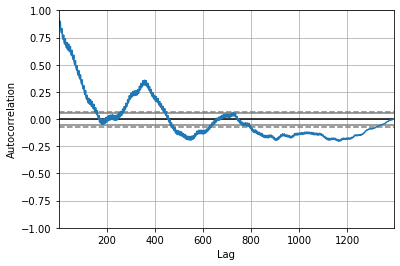

In [83]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y);

##### Y vs Y_pred

Matplotlib

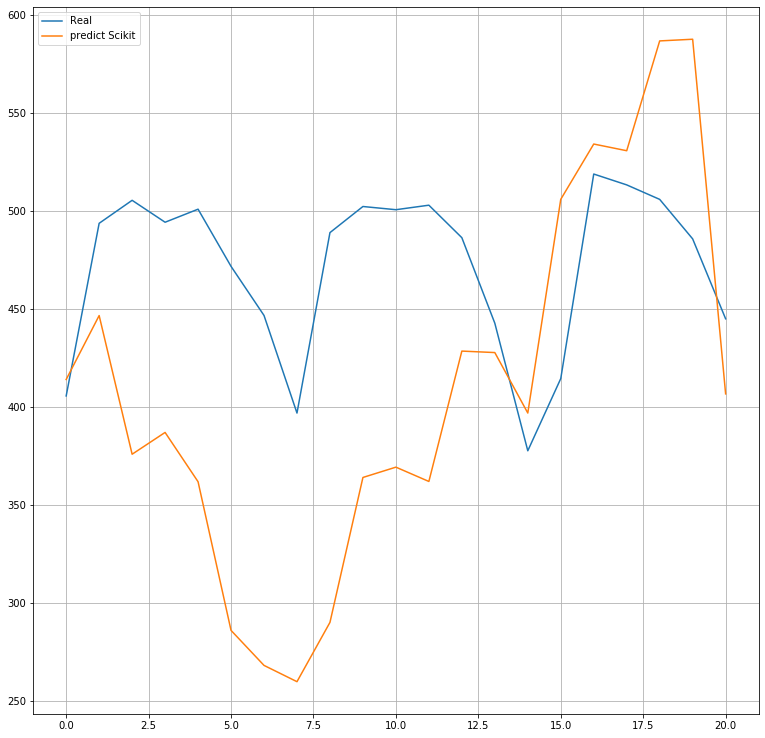

In [102]:
plt.figure(figsize=(13,13))
plt.plot(y[x].values, label="Real")
plt.plot(y_pred, label="predict Scikit")
plt.grid(True)
plt.legend()

plt.show()

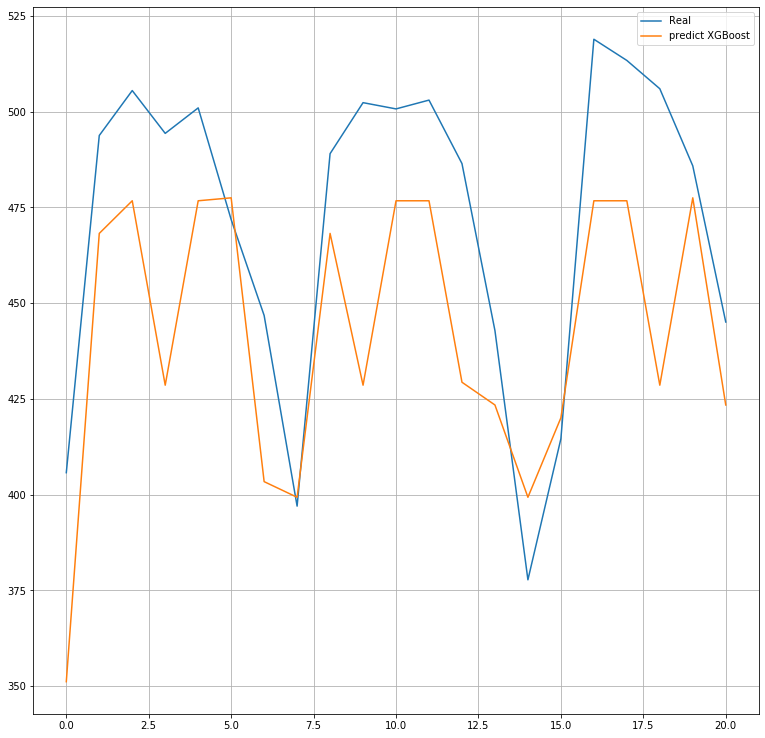

In [100]:
plt.figure(figsize=(13,13))
plt.plot(y[x].values, label="Real")
plt.plot(y_pred2, label="predict XGBoost")

plt.grid(True)
plt.legend()

plt.show()

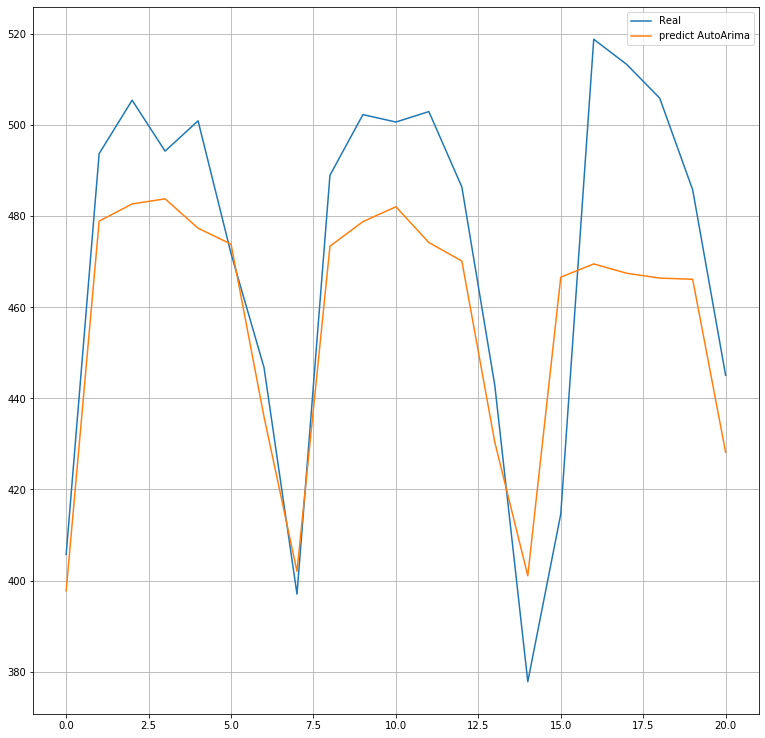

In [101]:
plt.figure(figsize=(13,13))
plt.plot(y[x2].values, label="Real")
plt.plot(y_pred3.values, label="predict AutoArima")
plt.grid(True)
plt.legend()

plt.show()